## Setup

In [43]:
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from EIANN import Network
import EIANN.utils as ut
import EIANN.plot as pt

from tqdm.autonotebook import tqdm
import numpy as np
import matplotlib.gridspec as gs
%load_ext autoreload
%autoreload 2

pt.update_plot_defaults()

def build_EIANN_from_config(config_path, network_seed=42):
    '''
    Build an EIANN network from a config file
    '''
    network_config = ut.read_from_yaml(config_path)
    layer_config = network_config['layer_config']
    projection_config = network_config['projection_config']
    training_kwargs = network_config['training_kwargs']
    network = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)
    return network


# Load dataset
tensor_flatten = T.Compose([T.ToTensor(), T.Lambda(torch.flatten)])
MNIST_train_dataset = torchvision.datasets.MNIST(root='../datasets/MNIST_data/', train=True, download=False,
                                         transform=tensor_flatten)
MNIST_test_dataset = torchvision.datasets.MNIST(root='../datasets/MNIST_data/',
                                        train=False, download=False,
                                        transform=tensor_flatten)

# Add index to train & test data
MNIST_train = []
for idx,(data,target) in enumerate(MNIST_train_dataset):
    target = torch.eye(len(MNIST_train_dataset.classes))[target]
    MNIST_train.append((idx, data, target))
    
MNIST_test = []
for idx,(data,target) in enumerate(MNIST_test_dataset):
    target = torch.eye(len(MNIST_test_dataset.classes))[target]
    MNIST_test.append((idx, data, target))
    
# Put data in dataloader
data_generator = torch.Generator()
train_dataloader = torch.utils.data.DataLoader(MNIST_train[0:50_000], batch_size=50_000)
train_sub_dataloader = torch.utils.data.DataLoader(MNIST_train[0:1000], shuffle=True, generator=data_generator, batch_size=1)
val_dataloader = torch.utils.data.DataLoader(MNIST_train[-10_000:], batch_size=10_000, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(MNIST_test, batch_size=10_000, shuffle=False)

epochs = 1
data_seed = 0
network_seed = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## bpDale angle comparison

In [260]:
# Build network
config_path = "../config/MNIST/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G.yaml"
bpDale_network = build_EIANN_from_config(config_path, network_seed=42)
saved_network_path = "../optimize/data/mnist/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G_66049_257_20000_steps.pkl"

# data_generator.manual_seed(data_seed)
# bpDale_network.train(train_dataloader, 
#                     test_dataloader, 
#                     epochs=epochs,
#                     val_interval=(0,-1,100),
#                     samples_per_epoch=20000,
#                     store_history=True, 
#                     store_params=True,
#                     status_bar=True)
# bpDale_network.save(path=saved_network_path)

bpDale_network.load(saved_network_path)

Loading model data from '../optimize/data/mnist/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G_66049_257_20000_steps.pkl'...
Loading parameters into the network...
Model successfully loaded from '../optimize/data/mnist/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G_66049_257_20000_steps.pkl'


In [261]:
# pt.plot_batch_accuracy(bpDale_network, test_dataloader)

In [262]:
bpDale_network

Network(
  (criterion): MSELoss()
  (module_dict): ModuleDict(
    (H1E_InputE): Projection(in_features=784, out_features=500, bias=False)
    (H1E_H1I): Projection(in_features=50, out_features=500, bias=False)
    (H1I_InputE): Projection(in_features=784, out_features=50, bias=False)
    (H1I_H1E): Projection(in_features=500, out_features=50, bias=False)
    (H1I_H1I): Projection(in_features=50, out_features=50, bias=False)
    (OutputE_H1E): Projection(in_features=500, out_features=10, bias=False)
    (OutputE_OutputI): Projection(in_features=10, out_features=10, bias=False)
    (OutputI_H1E): Projection(in_features=500, out_features=10, bias=False)
    (OutputI_OutputE): Projection(in_features=10, out_features=10, bias=False)
    (OutputI_OutputI): Projection(in_features=10, out_features=10, bias=False)
  )
  (parameter_dict): ParameterDict(
      (H1E_bias): Parameter containing: [torch.FloatTensor of size 500]
      (H1I_bias): Parameter containing: [torch.FloatTensor of size 50]


In [263]:
def recursive_dict_rename(my_dict, old_name, new_name):
    for key in list(my_dict):
        if key == old_name:
            my_dict[new_name] = my_dict.pop(old_name)
        elif isinstance(my_dict[key], dict):
            recursive_dict_rename(my_dict[key], old_name, new_name)
    return 

def rename_population(network, old_name, new_name):
    recursive_dict_rename(network.__dict__, old_name, new_name)

    # Rename populations in module_dict
    for key in list(network.module_dict):
        post_pop, pre_pop = key.split('_')

        for layer_name in list(network.layers):
            if pre_pop.startswith(layer_name):
                pre_pop_name = pre_pop[len(layer_name):]
                if pre_pop_name == old_name:
                    pre_pop = layer_name+new_name
            if post_pop.startswith(layer_name):
                post_pop_name = post_pop[len(layer_name):]
                if post_pop_name == old_name:
                    post_pop = layer_name+new_name
        new_key = f'{post_pop}_{pre_pop}'
        if new_key != key:
            network.module_dict[new_key] = network.module_dict.pop(key)

    # Rename populations in parameter_dict
    for key in list(network.parameter_dict):
        pop_fullname, param_name = key.split('_')

        for layer_name in list(network.layers):
            if pop_fullname.startswith(layer_name):
                pop_name = pop_fullname[len(layer_name):]
                if pop_name == old_name:
                    pop_fullname = layer_name+new_name
        new_key = f'{pop_fullname}_{param_name}'
        if new_key != key:
            network.parameter_dict[new_key] = network.parameter_dict.pop(key)

    # Rename populations in layers and projections
    for layer in network:
        recursive_dict_rename(layer.__dict__, old_name, new_name)
        for population in layer:
            if population.name == old_name:
                population.name = new_name
                population.fullname = layer.name+new_name
            recursive_dict_rename(population.__dict__, old_name, new_name)

            for projection in population:
                projection.name = f'{projection.post.layer.name}{projection.post.name}_{projection.pre.layer.name}{projection.pre.name}'


In [268]:
rename_population(bpDale_network, 'I', 'SomaI')
bpDale_network.save('saved_networks/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G_66049_257_20000_steps2.pkl')

Model saved to saved_networks/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G_66049_257_20000_steps2.pkl


In [46]:
# pt.plot_loss_landscape(test_dataloader, bpDale_network)

In [267]:
bpClone_network = ut.compute_alternate_dParam_history(train_dataloader, bpDale_network, save_path='saved_networks/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G_66049_257_20000_steps_bpClone.pkl')

# config_path = "../config/MNIST/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G2.yaml"
# bpClone_network = build_EIANN_from_config(config_path, network_seed=42)
# bpClone_network.load('saved_networks/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G_66049_257_20000_steps_bpClone.pkl')

  0%|          | 0/200 [00:00<?, ?it/s]

RuntimeError: Error(s) in loading state_dict for Network:
	Missing key(s) in state_dict: "module_dict.H1E_H1SomaI.weight", "module_dict.H1SomaI_InputE.weight", "module_dict.H1SomaI_H1E.weight", "module_dict.H1SomaI_H1SomaI.weight", "module_dict.OutputE_OutputSomaI.weight", "module_dict.OutputSomaI_H1E.weight", "module_dict.OutputSomaI_OutputE.weight", "module_dict.OutputSomaI_OutputSomaI.weight", "parameter_dict.H1SomaI_bias", "parameter_dict.OutputSomaI_bias". 
	Unexpected key(s) in state_dict: "module_dict.H1E_H1I.weight", "module_dict.H1I_InputE.weight", "module_dict.H1I_H1E.weight", "module_dict.H1I_H1I.weight", "module_dict.OutputE_OutputI.weight", "module_dict.OutputI_H1E.weight", "module_dict.OutputI_OutputE.weight", "module_dict.OutputI_OutputI.weight", "parameter_dict.H1I_bias", "parameter_dict.OutputI_bias". 

In [57]:
# angles = ut.compute_dW_angles(bpClone_network, plot=True)

In [24]:
del(bpDale_network.module_dict['H1E_H1I'])

In [39]:
name = 'OutputI_bias'
name2 = 'OutputSomaI_bias'
bpDale_network.parameter_dict[name2] = bpDale_network.parameter_dict[name]
del(bpDale_network.parameter_dict[name])

In [19]:
bpDale_network.H1.__dict__['SomaI'] = bpDale_network.H1.__dict__.pop(['I'])

TypeError: unhashable type: 'list'

In [44]:
bpDale_network.save(path='saved_networks/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G_66049_257_20000_steps_bpDale2.pkl')

Model saved to saved_networks/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G_66049_257_20000_steps_bpDale2.pkl


## BTSP angle comparison

In [10]:
# Build network
config_path = "../config/MNIST/20230822_EIANN_1_hidden_mnist_BTSP_config_G3.yaml"
btsp_network = build_EIANN_from_config(config_path, network_seed=42)

saved_network_path = "../optimize/data/mnist/20230822_EIANN_1_hidden_mnist_BTSP_config_G3_66049_257_20000_steps.pkl"
btsp_network.load(saved_network_path)

Loading model data from '../optimize/data/mnist/20230822_EIANN_1_hidden_mnist_BTSP_config_G3_66049_257_20000_steps.pkl'...
Loading parameters into the network...
Model successfully loaded from '../optimize/data/mnist/20230822_EIANN_1_hidden_mnist_BTSP_config_G3_66049_257_20000_steps.pkl'


In [13]:
btsp_network

Network(
  (criterion): MSELoss()
  (module_dict): ModuleDict(
    (H1E_InputE): Projection(in_features=784, out_features=500, bias=False)
    (H1E_H1SomaI): Projection(in_features=50, out_features=500, bias=False)
    (H1E_H1DendI): Projection(in_features=50, out_features=500, bias=False)
    (H1E_OutputE): Projection(in_features=10, out_features=500, bias=False)
    (H1SomaI_InputE): Projection(in_features=784, out_features=50, bias=False)
    (H1SomaI_H1E): Projection(in_features=500, out_features=50, bias=False)
    (H1SomaI_H1SomaI): Projection(in_features=50, out_features=50, bias=False)
    (H1DendI_H1E): Projection(in_features=500, out_features=50, bias=False)
    (H1DendI_H1DendI): Projection(in_features=50, out_features=50, bias=False)
    (OutputE_H1E): Projection(in_features=500, out_features=10, bias=False)
    (OutputE_OutputSomaI): Projection(in_features=10, out_features=10, bias=False)
    (OutputSomaI_H1E): Projection(in_features=500, out_features=10, bias=False)
    (

In [42]:
btsp_comparison_network = ut.compute_alternate_dParam_history(train_dataloader, btsp_network, bpDale_network, save_path='saved_networks/20230822_EIANN_1_hidden_mnist_BTSP_config_G3_66049_257_20000_steps_bpClone.pkl')

  0%|          | 0/200 [00:00<?, ?it/s]

/Users/ag1880/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([50000, 10])) that is different to the input size (torch.Size([10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Model saved to saved_networks/20230822_EIANN_1_hidden_mnist_BTSP_config_G3_66049_257_20000_steps_bpClone.pkl


/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/utils.py:1229: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


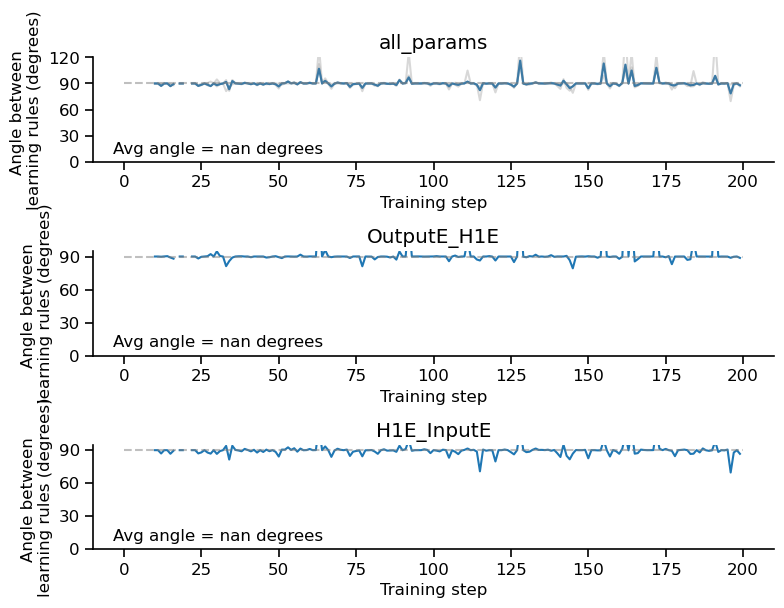

In [43]:
angles = ut.compute_dW_angles(btsp_comparison_network, plot=True)